# TRAINING CAMP KPMG
Gianluca Procopio, 1942103   
Giorgio Bertone, 2112729   
Filippo Parlanti, 2136988   
Himel Ghosh, 2102750   

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

In [134]:
df_train = pd.read_csv('train.csv')

In [135]:
df_train

,volume_kg,distribution_channel,customer,brand,channel,store_format,category,year,month
0,460.026585,0,1,1,FOOD SERVICE,3,3,2010,1
1,456.944328,0,1,1,FOOD SERVICE,3,3,2010,2
2,926.790243,0,1,1,FOOD SERVICE,3,3,2010,3
3,762.549167,0,1,1,FOOD SERVICE,3,3,2010,4
4,1132.060704,0,1,1,FOOD SERVICE,3,3,2010,5
...,...,...,...,...,...,...,...,...,...
5788,938.077344,1,15,1,DISCOUNTS,1,10,2019,12
5789,464.815891,1,15,1,DISCOUNTS,1,10,2020,1
5790,471.421097,1,15,1,DISCOUNTS,1,10,2020,2
5791,12611.841468,1,15,1,DISCOUNTS,1,10,2020,3


In [136]:
df_train["serie_name"] = pd.concat([df_train["distribution_channel"], df_train["customer"], df_train["brand"], df_train["channel"], df_train["store_format"], df_train["category"]], axis=1).apply(lambda x: f"{x[0]}_{x[1]}_{x[2]}_{x[3]}_{x[4]}_{x[5]}", axis=1)
df_train

,volume_kg,distribution_channel,customer,brand,channel,store_format,category,year,month,serie_name
0,460.026585,0,1,1,FOOD SERVICE,3,3,2010,1,0_1_1_FOOD SERVICE_3_3
1,456.944328,0,1,1,FOOD SERVICE,3,3,2010,2,0_1_1_FOOD SERVICE_3_3
2,926.790243,0,1,1,FOOD SERVICE,3,3,2010,3,0_1_1_FOOD SERVICE_3_3
3,762.549167,0,1,1,FOOD SERVICE,3,3,2010,4,0_1_1_FOOD SERVICE_3_3
4,1132.060704,0,1,1,FOOD SERVICE,3,3,2010,5,0_1_1_FOOD SERVICE_3_3
...,...,...,...,...,...,...,...,...,...,...
5788,938.077344,1,15,1,DISCOUNTS,1,10,2019,12,1_15_1_DISCOUNTS_1_10
5789,464.815891,1,15,1,DISCOUNTS,1,10,2020,1,1_15_1_DISCOUNTS_1_10
5790,471.421097,1,15,1,DISCOUNTS,1,10,2020,2,1_15_1_DISCOUNTS_1_10
5791,12611.841468,1,15,1,DISCOUNTS,1,10,2020,3,1_15_1_DISCOUNTS_1_10


In [137]:
print("Number of unique time series: ", df_train["serie_name"].nunique())

Number of unique time series:  48


Example plot of one serie

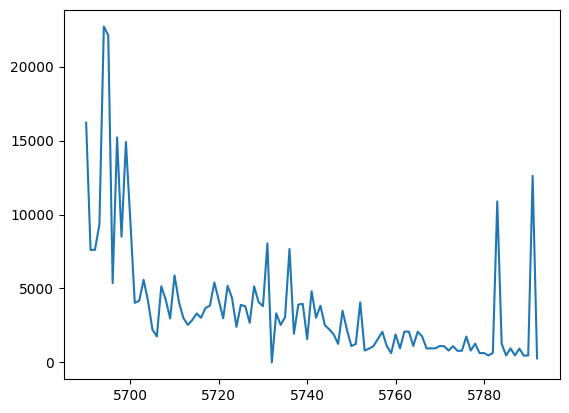

In [138]:
ts1 = df_train[df_train["serie_name"] == "1_15_1_DISCOUNTS_1_10"]
plt.plot(ts1.index, ts1["volume_kg"])

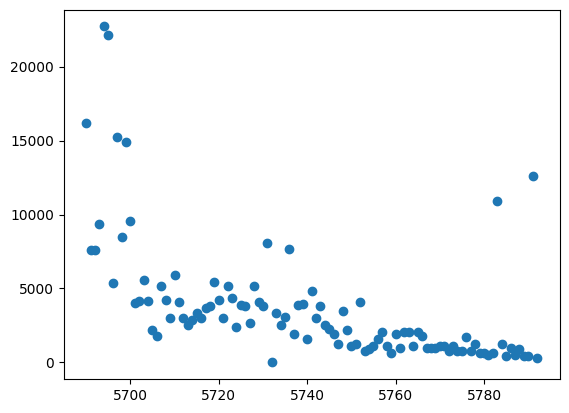

In [139]:
plt.scatter(ts1.index, ts1["volume_kg"])

In [140]:
ts1.drop(["distribution_channel", "customer", "brand", "channel", "store_format", "category"], axis=1, inplace=True)

In [141]:
ts1

,volume_kg,year,month,serie_name
5690,16204.744324,2010,1,1_15_1_DISCOUNTS_1_10
5691,7598.342304,2010,3,1_15_1_DISCOUNTS_1_10
5692,7617.416265,2010,4,1_15_1_DISCOUNTS_1_10
5693,9333.721886,2010,5,1_15_1_DISCOUNTS_1_10
5694,22708.317207,2010,7,1_15_1_DISCOUNTS_1_10
...,...,...,...,...
5788,938.077344,2019,12,1_15_1_DISCOUNTS_1_10
5789,464.815891,2020,1,1_15_1_DISCOUNTS_1_10
5790,471.421097,2020,2,1_15_1_DISCOUNTS_1_10
5791,12611.841468,2020,3,1_15_1_DISCOUNTS_1_10


In [142]:
# Convert to datetime
df_train['date'] = pd.to_datetime(df_train[['year', 'month']].assign(day=1))
df_train.set_index(["serie_name",'date'], inplace=True)

In [143]:
df_train.drop(["distribution_channel", "customer", "brand", "channel", "store_format", "category","year", "month"], axis=1, inplace=True)

In [144]:
df_train

volume_kg
serie_name             date                    
0_1_1_FOOD SERVICE_3_3 2010-01-01    460.026585
                       2010-02-01    456.944328
                       2010-03-01    926.790243
                       2010-04-01    762.549167
                       2010-05-01   1132.060704
...                                         ...
1_15_1_DISCOUNTS_1_10  2019-12-01    938.077344
                       2020-01-01    464.815891
                       2020-02-01    471.421097
                       2020-03-01  12611.841468
                       2020-04-01    277.491080

[5793 rows x 1 columns]

Impute missing values

In [145]:
total = pd.DataFrame()
for ts in df_train.index.get_level_values(0).unique():
    aux = df_train.loc[ts]
    aux = aux.asfreq('MS')
    df_interpolated = aux.interpolate(method='time')
    df_interpolated['serie_name'] = [ts] * len(aux)
    df_interpolated = df_interpolated.set_index(['serie_name'],append=True)
    total = pd.concat([total,df_interpolated], axis=0)

total = total.swaplevel()
total

volume_kg
serie_name             date                    
0_1_1_FOOD SERVICE_3_3 2010-01-01    460.026585
                       2010-02-01    456.944328
                       2010-03-01    926.790243
                       2010-04-01    762.549167
                       2010-05-01   1132.060704
...                                         ...
1_15_1_DISCOUNTS_1_10  2019-12-01    938.077344
                       2020-01-01    464.815891
                       2020-02-01    471.421097
                       2020-03-01  12611.841468
                       2020-04-01    277.491080

[5834 rows x 1 columns]

In [146]:
df_train = total

# NEURALPROPHET

In [ ]:
import matplotlib as plt
from neuralprophet import NeuralProphet
import pandas as pd
import numpy as np
from tqdm import tqdm

def create_submission(df_train):
    unique_series = df_train.index.get_level_values(0).unique()
    all_predictions = []

    progress_bar = tqdm(total=len(unique_series))
    progress_bar.set_description("Evaluating series")

    for series in unique_series:
        ts1 = df_train.loc[series]
        ts1 = ts1.reset_index()
        ts1.rename(columns={'date': 'ds', 'volume_kg': 'y'}, inplace=True)

        # Log-transform the data
        ts1['y'] = np.log(ts1['y'])

        # Initialize NeuralProphet model
        model = NeuralProphet(seasonality_mode='additive',yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
        
        # Fit the model
        model.fit(ts1, freq='MS')

        # Create future dataframe
        future = model.make_future_dataframe(ts1,periods=4)
        
        # Make predictions
        forecast = model.predict(future)


        # Exponentiate the predictions to revert to the original scale
        forecast['yhat1'] = np.exp(forecast['yhat1'])

        # Create predictions DataFrame
        predictions_df = forecast[['ds', 'yhat1']]
        predictions_df.set_index('ds', inplace=True)
        predictions_df.rename(columns={'yhat1': 'volume_kg'}, inplace=True)
        print(predictions_df)

        for date, volume in predictions_df.iterrows():
            all_predictions.append({
                'id': f"{date.year}_{date.month}_{series}",
                'volume_kg': volume['volume_kg']
            })

        progress_bar.update(1)

    progress_bar.close()

    # Create submission DataFrame
    submission_df = pd.DataFrame(all_predictions)
    submission_df.to_csv('submission.csv', index=False)
    print("Submission file created with name 'submission.csv'")

create_submission(df_train)